- https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn
- https://heytech.tistory.com/434

In [10]:
import argparse
import os 
import csv
import wandb
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
# from timm import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models
import timm
from torch.utils.data import DataLoader, WeightedRandomSampler, default_collate
import random
from tqdm import tqdm
import time
from collections import OrderedDict

from Dataset_ML2 import *
from utils_ML2 import *
from models_ML2 import *
from LUVM_v2 import *

import vidaug.augmentors as va

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve

import math
from sklearn.preprocessing import OneHotEncoder

In [11]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)

In [12]:
def models_output_to_dataframe(df, fold_num, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{fold_num}_{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

In [13]:
def resize_ratio(img, img_resolution):
    # 만약 img_path가 들어올 경우 아래 코드 실행
    # pic_1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    resized_pic = np.zeros((img_resolution, img_resolution, 3), np.uint8)
    h,w = img.shape[:2]
    
    ash = img_resolution/h
    asw = img_resolution/w
    if asw<ash:
        sizeas=(int(w*asw),int(h*asw))
    else:
        sizeas=(int(w*ash),int(h*ash))
        
    img = cv2.resize(img,dsize=sizeas)
    resized_pic[int(img_resolution/2-sizeas[1]/2):int(img_resolution/2+sizeas[1]/2),
    int(img_resolution/2-sizeas[0]/2):int(img_resolution/2+sizeas[0]/2),:]=img
    
    return resized_pic

In [14]:
def apply_transform(mode):
    
    if mode == 'train':
        transform = A.Compose([
                    A.OneOf([
                        A.CLAHE(clip_limit=8.0, tile_grid_size=(8, 8),always_apply=False, p=1)
                        ], p=0.3),
                    A.HorizontalFlip(p=0.5),
                    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_REPLICATE),
                    A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225),
                        max_pixel_value=255.0,
                        always_apply=False,
                        p=1.0,),
                    ToTensorV2()
                    ])
    else:
          transform = A.Compose([
                    A.Normalize(mean=(0.485, 0.456, 0.406),
                        std=(0.229, 0.224, 0.225),
                        max_pixel_value=255.0,
                        always_apply=False,
                        p=1.0,),
                    ToTensorV2()
                    ])
          
    return transform

In [15]:
class frame_dataset(Dataset):
    """ Video Dataset.
    
    """
    def __init__(self, csv_path, img_resolution, transforms): 
        
        self.csv_path = csv_path
        self.img_resolution = img_resolution
        self.transforms = transforms
        
        self.df = pd.read_csv(self.csv_path)
        self.label_list = [int(i) for i in self.df['Lung ultrasound score_lbl']] 
        self.img_path_list = [str(i) for i in self.df['img_path']] 

        # 4 artifacts class-
        self.PRED_LABEL = [
            'A-line_lbl',
            'total-B-line_lbl',
#             'B-line_lbl',
            'Consolidation_lbl',
            'Pleural effusion_lbl'
            ]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
         
        img = cv2.cvtColor(cv2.imread(self.img_path_list[idx]), cv2.COLOR_BGR2RGB)

        img = resize_ratio(img, self.img_resolution)
        
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)

        label = torch.FloatTensor(np.zeros(len(self.PRED_LABEL), dtype=float))
        
        for i in range(0, len(self.PRED_LABEL)):
            if (self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float')
                
        if self.transforms is not None:
            
            img = self.transforms(image=img)["image"]
            
            return img, label

In [28]:
def frame_level_test(probe_type, frame_size, weight_path, base_path, batch_size):
    
    if probe_type == 'all':
        # frame-level csv path
        test_csv_path = os.path.join(base_path, f'CAUH/CAUH_test.csv')
    elif probe_type == 'no_linear':
        # frame-level csv path
        test_csv_path = os.path.join(base_path, f'CAUH/CAUH_nolinear_test.csv')
        

    # dataset
    test_dataset = frame_dataset(test_csv_path, img_resolution = frame_size, transforms = apply_transform(mode=None))
    
    # dataloader
    test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, drop_last=False)
    
    #len_dataloader
    len_test_dataset = len(test_dataloader.dataset)
    print(len_test_dataset)
    
    # set seed
    set_all_seeds(1234)
    
    sigmoid = nn.Sigmoid()
    
    gpu_index = 3
    device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

    model = timm.create_model('densenet161', pretrained=False, num_classes=4)
    
    model = model.to(device)
    
    check_point = torch.load(weight_path, map_location=device)
    
    if 'module' in list(check_point['model'].keys())[0]:
        # If so, remove the 'module.' prefix from the keys in the state_dict
        new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
        model.load_state_dict(new_state_dict)
    else:
        # If not using DataParallel, simply load the state_dict
        model.load_state_dict(check_point['model'])
    
    best_val_thres = check_point['best_valid_thres']
    print(best_val_thres)

    model_outputs = []
    test_labels = []
    test_preds = []
    
    #acc
    test_running_acc = 0.0
    
    model.eval() 
    with torch.no_grad():    
            
        for data in tqdm(test_dataloader, desc="Testing", unit="batch"):
            
            test_img, test_label = data
            
            test_img = test_img.float().to(device)
            test_label = test_label.to(device)
            
            test_output = model(test_img)
            test_output = sigmoid(test_output.squeeze())
            # test_output = F.softmax(test_output, dim = 1)
            
            model_outputs.append(test_output.cpu().detach().numpy().tolist())
            
            test_preds_np = test_output.data.cpu().numpy()
            
            test_preds_np = np.where(test_preds_np >= best_val_thres, 1, 0)
#             test_preds_np = np.where(test_preds_np >= 0.5, 1, 0)
            
            test_preds.append(test_preds_np.tolist())
            test_labels.append(test_label.detach().cpu().numpy().tolist())
            
            np_test_label = test_label[0].cpu().numpy()
            
            test_accuracy = accuracy_score(np_test_label, test_preds_np)
            
            test_running_acc += test_accuracy
            
            # print(f"prediction : {test_preds_np}, test_label : {np_test_label}")
            # print(f"correct_num : {test_accuracy}")
            # print('-'*20)
    
    test_accuracy = test_running_acc / len_test_dataset
    print(f"test_running_acc : {test_running_acc}")
    
    return test_accuracy, test_labels, test_preds, model_outputs, best_val_thres

In [79]:
probe_type = 'no_linear'

chk_std = "loss"

model_test_rate = "0.2"

fold_num = 4

version = 'version_1'

lr = 1e-6

data_type = "before_all_data"

frame_size = 256

batch_size = 128

# seed_num = 1234
seed_num = 234

# artifacts = 4
artifacts = 5

chk_std = "loss"

model_name = 'densenet161'

weight_path = f'/data2/hoon2/Results/frame_base/seed_{seed_num}_test{model_test_rate}_std_{chk_std}_{data_type}_{version}_{artifacts}_artifacts_{model_name}_lr{lr}_batch{batch_size}_{frame_size}_fold{fold_num}_noaug_checkpoint'

base_path = f'/data2/hoon2/LUS_Dataset/csv_files/'

is_train = False

In [80]:
base_path = f'/data2/hoon2/LUS_Dataset/csv_files/'

test_accuracy, test_labels, test_preds, model_output, best_val_thres = frame_level_test(probe_type = probe_type,
                                                                                        frame_size = frame_size, 
                                                                                        weight_path=weight_path, 
                                                                                        base_path=base_path, 
                                                                                        batch_size=1)

276
[0.14718693, 0.08498128, 0.12685402, 0.21887156]


Testing:  73%|███████▎  | 202/276 [00:11<00:04, 17.37batch/s]

Testing: 100%|██████████| 276/276 [00:14<00:00, 18.79batch/s]

test_running_acc : 139.5


In [81]:
labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_output_df = pd.DataFrame(columns=labels)

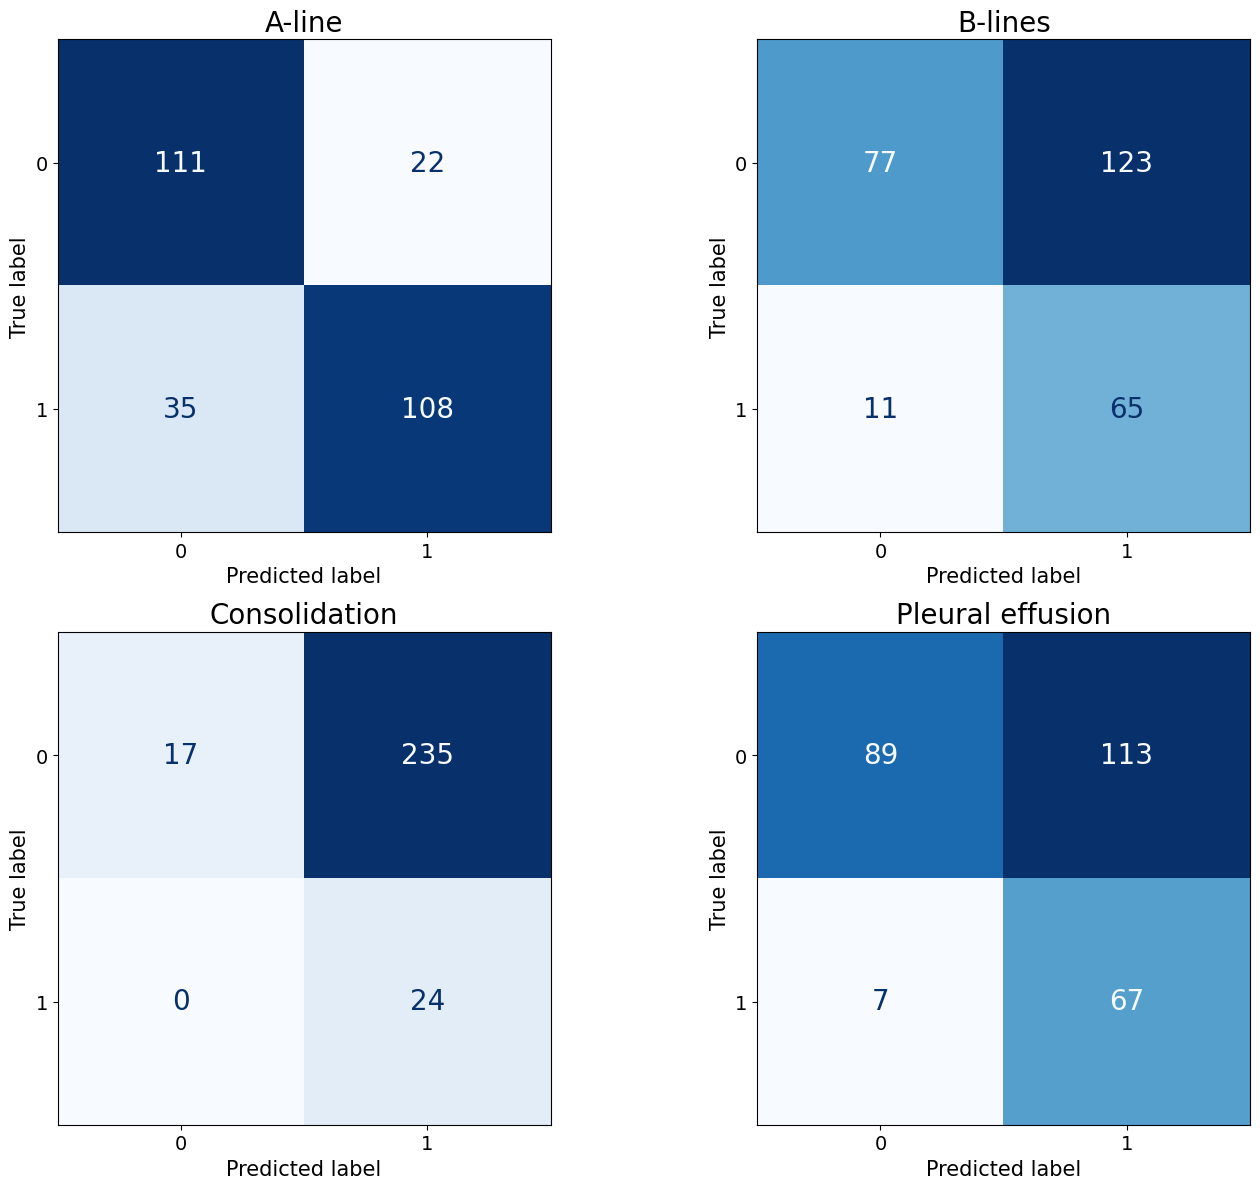

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

test_labels = [idx[0] for idx in test_labels]
test_labels = [[int(y) for y in z] for z in test_labels]

confusion_mat = multilabel_confusion_matrix(test_labels, test_preds)

all_labels = [
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# axs는 2x3 array이므로 axs.flat으로 iterator를 생성합니다.
ax_iterator = iter(axs.flat)

for idx, label in enumerate(all_labels):
    ax = next(ax_iterator)  # 다음 subplot을 가져옵니다.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat[idx], display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)  # 각 subplot에 colorbar를 제거합니다.
    ax.set_title(label, fontsize=20)  # 레이블의 글자 크기를 조정합니다.
    
    # 각 축에 대해 텍스트 크기를 설정합니다.
    ax.set_xlabel('Predicted label', fontsize=15)  # x축 라벨 크기 설정
    ax.set_ylabel('True label', fontsize=15)       # y축 라벨 크기 설정
    ax.tick_params(axis='both', which='major', labelsize=14)  # 축 글자 크기 설정
    
    for texts in [disp.text_]:
        for text in texts.flatten():
            text.set_fontsize(20)  # 숫자 텍스트의 크기를 조정합니다.

# 남는 subplot을 숨깁니다.
for ax in ax_iterator:
    ax.set_visible(False)

plt.tight_layout()  # 자동으로 레이아웃을 맞추어 간격을 조정합니다.
plt.show()

In [83]:
# precision_score, recall_score, f1_score 함수를 사용하여 각 레이블별 성능을 계산합니다.
from sklearn.metrics import precision_score, recall_score, f1_score

test_prediction_flat = np.array(test_preds).flatten()
test_labels_flat = np.array(test_labels).flatten()

precision = precision_score(test_labels_flat, test_prediction_flat, average='weighted')
recall = recall_score(test_labels_flat, test_prediction_flat, average='weighted')
f1 = f1_score(test_labels_flat, test_prediction_flat, average='weighted')

print('Micro-averaged precision : ', precision)
print('recall : ', recall)
print('f1-score : ', f1)

Micro-averaged precision :  0.7041191745521108
recall :  0.5054347826086957
f1-score :  0.5107949723669098


In [84]:
print(classification_report(
    test_labels,
    test_preds,
    output_dict=False,
    target_names=[
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]
))

                  precision    recall  f1-score   support

          A-line       0.83      0.76      0.79       143
         B-lines       0.35      0.86      0.49        76
   Consolidation       0.09      1.00      0.17        24
Pleural effusion       0.37      0.91      0.53        74

       micro avg       0.35      0.83      0.49       317
       macro avg       0.41      0.88      0.50       317
    weighted avg       0.55      0.83      0.61       317
     samples avg       0.37      0.82      0.48       317



In [85]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 0], np.array(model_output)[:, 0])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('A-line results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 0] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 0], y_prob_pred, target_names=['A-line', 'Others']))

A-line results
Best Threshold=0.141839, sensitivity = 0.790, specificity = 0.812, J=0.602
              precision    recall  f1-score   support

      A-line       0.78      0.81      0.80       133
      Others       0.82      0.79      0.80       143

    accuracy                           0.80       276
   macro avg       0.80      0.80      0.80       276
weighted avg       0.80      0.80      0.80       276



In [86]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 1], np.array(model_output)[:, 1])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('B-lines results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 1] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 1], y_prob_pred, target_names=['B-line', 'Others']))

B-lines results
Best Threshold=0.149321, sensitivity = 0.658, specificity = 0.800, J=0.458
              precision    recall  f1-score   support

      B-line       0.86      0.80      0.83       200
      Others       0.56      0.66      0.60        76

    accuracy                           0.76       276
   macro avg       0.71      0.73      0.72       276
weighted avg       0.78      0.76      0.77       276



In [87]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 2], np.array(model_output)[:, 2])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# print('Confluent B-line results')
print('Consolidation')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 2] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 2], y_prob_pred, target_names=['Confluent B-line', 'Others']))

Consolidation
Best Threshold=0.399705, sensitivity = 0.833, specificity = 0.647, J=0.480
                  precision    recall  f1-score   support

Confluent B-line       0.98      0.65      0.78       252
          Others       0.18      0.83      0.30        24

        accuracy                           0.66       276
       macro avg       0.58      0.74      0.54       276
    weighted avg       0.91      0.66      0.74       276



In [88]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 3], np.array(model_output)[:, 3])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Pleural effusion results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 3] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 3], y_prob_pred, target_names=['Pleural effusion', 'Others']))

Pleural effusion results
Best Threshold=0.356185, sensitivity = 0.757, specificity = 0.906, J=0.663
                  precision    recall  f1-score   support

Pleural effusion       0.91      0.91      0.91       202
          Others       0.75      0.76      0.75        74

        accuracy                           0.87       276
       macro avg       0.83      0.83      0.83       276
    weighted avg       0.87      0.87      0.87       276



In [89]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

current_thresholds = []
fpr = dict()
tpr = dict()
roc_auc = dict()
thres = dict()

for i in range(4):
    # 각 클래스별 ROC curve 계산
    fpr[i], tpr[i], thres[i] = roc_curve(np.array(test_labels)[:, i], np.array(model_output)[:, i])
    
    # AUC 계산
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Youden's J statistic을 사용하여 최적의 threshold를 찾기
    J = tpr[i] - fpr[i]
    ix = np.argmax(J)
    
    # 최적의 threshold 추가 (thres[1:] 사용 시 첫 번째 값 제외)
    current_thresholds.append(thres[i][ix])

print(f"Best threshold for each label: {current_thresholds}")

Best threshold for each label: [0.14183945953845978, 0.14932118356227875, 0.39970454573631287, 0.35618481040000916]


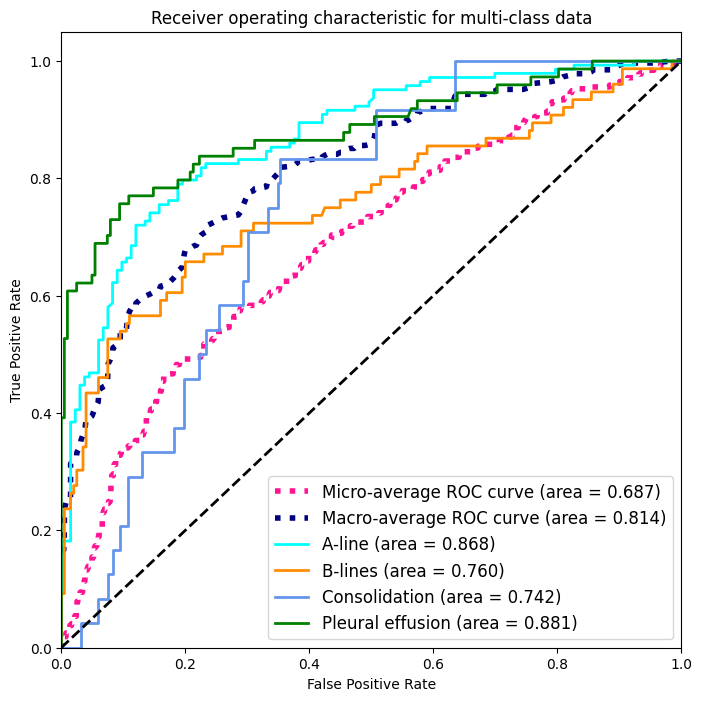

In [90]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc


# ROC curve를 계산하고 시각화합니다.
n_classes = len(test_labels[0])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(test_labels)[:, i], np.array(model_output)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve를 계산합니다.
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(test_labels).ravel(), np.array(model_output).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 모든 레이블에 대한 평균 ROC curve를 계산합니다.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC curve를 그래프로 시각화합니다.
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
all_labels = [
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]

for i, label, color in zip(range(len(all_labels)), all_labels, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='{0} (area = {1:0.3f})'
            ''.format(label, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right", fontsize='large')
plt.show()

In [78]:
models_output_df

Empty DataFrame
Columns: [A-line, total-B-line, Consolidation, Pleural effusion]
Index: []

In [118]:
models_output_df = models_output_to_dataframe(models_output_df, fold_num, labels, model_output)
models_output_df.head()

4_A-line  4_total-B-line  4_Consolidation  4_Pleural effusion
0  0.062115        0.092062         0.461969            0.227999
1  0.196830        0.087090         0.363350            0.127195
2  0.119176        0.270931         0.240392            0.179967
3  0.128263        0.091600         0.496220            0.175540
4  0.090195        0.075803         0.463653            0.142158

In [119]:
def gt_to_dataframe(df, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

frame_models_gt_df = pd.DataFrame(columns=labels)

frame_models_gt_df = gt_to_dataframe(frame_models_gt_df, labels, test_labels)
frame_models_gt_df.head()

A-line  total-B-line  Consolidation  Pleural effusion
0       0             1              1                 1
1       1             0              0                 0
2       0             1              0                 0
3       0             0              0                 0
4       0             0              0                 0

In [120]:
os.makedirs('/data2/hoon2/Results/model_output_csv/CAUH_frame_level/', exist_ok=True)
models_output_df.to_csv(f'/data2/hoon2/Results/model_output_csv/CAUH_frame_level/2d_model_fold_{fold_num}_frame_output.csv', index = False)

In [121]:
frame_models_gt_df.to_csv(f'/data2/hoon2/Results/model_output_csv/CAUH_frame_level/5_artifacts_frame_level_gt.csv', index = False)

## Grad-CAM
- https://honbul.tistory.com/54

In [25]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.utils import make_grid, save_image
from torchvision.transforms import Compose, Normalize, ToTensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import cv2
from tqdm import tqdm

In [26]:
def load_model(model_name, num_classes):
    # 지원되는 모델에 대해 모델을 로드하고 수정
    if model_name == 'densenet161':
        model = models.densenet161(pretrained=True)
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'resnet152':
        model = models.resnet152(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'resnext101_32x8d':
        model = models.resnext101_32x8d(pretrained=True)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    return model

In [27]:
def preprocess_image(
    img: np.ndarray, mean=[
        0.5, 0.5, 0.5], std=[
            0.5, 0.5, 0.5]) -> torch.Tensor:
    preprocessing = Compose([
        ToTensor(),
        Normalize(mean=mean, std=std)
    ])
    return preprocessing(img.copy()).unsqueeze(0)

In [28]:
def resize_ratio(img, img_resolution):
    # 만약 img_path가 들어올 경우 아래 코드 실행
    # pic_1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    resized_pic = np.zeros((img_resolution, img_resolution, 3), np.uint8)
    h,w = img.shape[:2]
    
    ash = img_resolution/h
    asw = img_resolution/w
    if asw<ash:
        sizeas=(int(w*asw),int(h*asw))
    else:
        sizeas=(int(w*ash),int(h*ash))
        
    img = cv2.resize(img,dsize=sizeas)
    resized_pic[int(img_resolution/2-sizeas[1]/2):int(img_resolution/2+sizeas[1]/2),
    int(img_resolution/2-sizeas[0]/2):int(img_resolution/2+sizeas[0]/2),:]=img
    
    return resized_pic

In [30]:
class grad_dataset(Dataset):
    """ Video Dataset.
    
    """
    def __init__(self, csv_path, img_resolution, transforms): 
        
        self.csv_path = csv_path
        self.img_resolution = img_resolution
        self.transforms = transforms
        
        self.df = pd.read_csv(self.csv_path)
        self.label_list = [int(i) for i in self.df['Lung ultrasound score_lbl']] 
        self.img_path_list = [str(i) for i in self.df['img_path']] 
        
        self.PRED_LABEL = [
            'A-line_lbl',
            'total-B-line_lbl',
            'Consolidation_lbl',
            'Pleural effusion_lbl'
            ]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
         
        img = cv2.cvtColor(cv2.imread(self.img_path_list[idx]), cv2.COLOR_BGR2RGB)

        img = resize_ratio(img, self.img_resolution)
        
        path = self.df['img_path'].iloc[idx]
        
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]
            img = np.concatenate([img, img, img], axis=2)

        label = torch.FloatTensor(np.zeros(len(self.PRED_LABEL), dtype=float))
        
        for i in range(0, len(self.PRED_LABEL)):
            if (self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float') > 0):
                label[i] = self.df[self.PRED_LABEL[i].strip()].iloc[idx].astype('float')
                
        if self.transforms is not None:
            
            img = self.transforms(image=img)["image"]
            
            return img, label, path

In [50]:
model_name = 'densenet161'

version = 'version_1'
frame_size = 256
fold_num = 0
model_test_rate = "0.2"
chk_std = "loss"

#     data_type = "all_data"
#     data_type = "before_all_data_test"
data_type = "before_all_data"
    
batch_size = 1

weight_path = f'/home/work/LUS/Results/frame_base/multi_label/test{model_test_rate}_std_{chk_std}_{data_type}_{version}_4_artifacts_densenet161_batch32_256_fold{fold_num}_checkpoint'
    
base_path = '/home/work/LUS/Dataset/csv_files/frame_multilabel_classification'
output_dir = f'/home/work/LUS/Results/Grad_CAM/multi_label/4_artifacts/{data_type}/{version}/{model_name}_{fold_num}_fold_v2'

In [33]:
num_classes=4

# case 2 : 3 class
test_csv_path = os.path.join(base_path, f'{data_type}/{version}/{num_classes}_artifacts/test_{model_test_rate}/fold_{fold_num}/test.csv')

# dataset
grad_test_dataset = grad_dataset(test_csv_path, img_resolution = 256, transforms = apply_transform(mode=None))    
grad_test_dataloader =  torch.utils.data.DataLoader(grad_test_dataset, batch_size=1, shuffle = False, drop_last=False)
# set seed
set_all_seeds(1234)

sigmoid = nn.Sigmoid()

# load imagenet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
model.classifier=nn.Linear(model.classifier.in_features, num_classes,bias=True)

gpu_index = 0
device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

check_point = torch.load(weight_path, map_location=device)

# torch.nn.DataParallel을 사용하여 모델을 학습하고 저장한 경우에 이러한 접두어가 자주 발생
if 'module' in list(check_point['model'].keys())[0]:
    # If so, remove the 'module.' prefix from the keys in the state_dict
    new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
    model.load_state_dict(new_state_dict)
else:
    # If not using DataParallel, simply load the state_dict
    model.load_state_dict(check_point['model'])
    
# load best threshold
best_val_thres = check_point['best_valid_thres']
model = model.to(device) 

Using cache found in /home/work/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
print(f'best_threshold : {best_val_thres}')

best_threshold : [0.43832314, 0.02819881, 0.3515713, 0.030516304]


In [35]:
layer = model.features.norm5
cam = GradCAM(model=model, target_layers=[layer])
# cam = AblationCAM(model=model, target_layers=[layer])

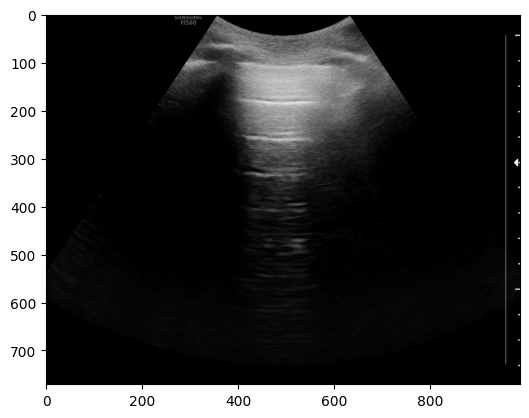

In [49]:
ex_path = '/home/work/LUS/Dataset/dcm_to_png_v1/all_frame/version_1/30625107/30625107_00003_1.png'
img = cv2.imread(ex_path)
plt.imshow(img)

(729, 989, 3)
(256, 256, 3)


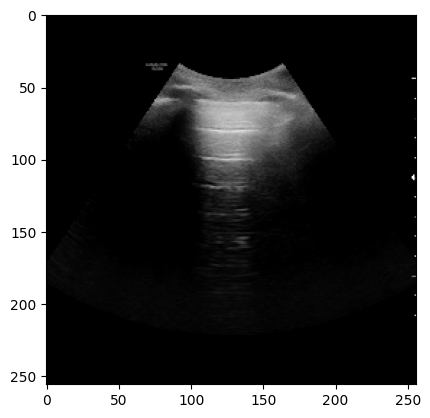

In [48]:
rgb_img = cv2.imread(org_img_path[0], 1)
print(rgb_img.shape)
rgb_img = resize_ratio(rgb_img, 256)
print(rgb_img.shape)
rgb_img = np.float32(rgb_img) / 255
plt.imshow(rgb_img)

  0% 0/6139 [00:00<?, ?it/s]

/home/work/LUS/Dataset/dcm_to_png/all_frame/version_1/30625107/30625107_00003_1.png


  0% 0/6139 [00:02<?, ?it/s]


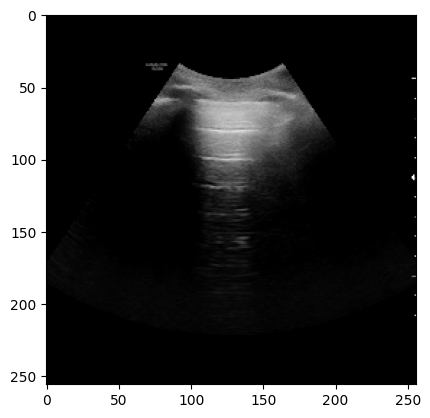

In [45]:
from PIL import Image

LABEL_INT2STR = {0:'A-line', 
                 1:'B-lines',
                 2:'Consolidation',
                 3:'Pleural effusion'}

for idx, data in tqdm(enumerate(grad_test_dataloader), total=len(grad_test_dataloader)):
    
    img, label, org_img_path = data
    
    print(org_img_path[0])
    
    # grad_cam input img load
#     rgb_img = cv2.imread(org_img_path[0], 1)
    rgb_img = cv2.imread(org_img_path[0])
    rgb_img = resize_ratio(rgb_img, 256)
    rgb_img = np.float32(rgb_img) / 255
    plt.imshow(rgb_img)
    # model input load 
    label_np = label.numpy()
    
    label_idx = np.where(label_np == 1)[1]
    labels_lst = [LABEL_INT2STR[idx] for idx in label_idx]
    all_labels = ' , '.join(labels_lst) 

    img = img.to(device)
    test_output = model(img)
    test_output = sigmoid(test_output.squeeze())
    
    test_preds_np = test_output.data.cpu().numpy()
    
    binary_test_output = np.where(test_preds_np >= best_val_thres, 1, 0)
#     binary_test_output = np.where(test_preds_np >= 0.5, 1, 0) 
    
    class_cam_image = []
    
    for l in range(len(LABEL_INT2STR)):
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(l)],aug_smooth=True,eigen_smooth=False)
        grayscale_cam = grayscale_cam[0, :]
        class_cam_image.append(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True))
    
    fig,ax = plt.subplots(1, 5, figsize=(20, 15))
    
    ax[0].imshow(rgb_img)
#     ax[0].imshow(original_img)
    ax[0].set_title(f'original image({all_labels})')
#     ax[0].axis('off')
    
    for l in range(len(LABEL_INT2STR)):
        ax[l+1].imshow(class_cam_image[l])
        ax[l+1].set_title(f'{LABEL_INT2STR[l]}(Conf:{test_preds_np[l]:.5f})')
        ax[l+1].axis('off')
    
    labels_str_ = ', '.join(label_np.astype(int).astype(str)[0])
    test_preds_values = [round(value, 5) for value in list(test_preds_np)]
    
    patient_id = org_img_path[0].split('/')[-1].split('.')[0]
    plt.suptitle(f'file_name: {patient_id} | ground truth: {all_labels}([{labels_str_}]) | thresholds: {best_val_thres}',y=.63)
    labels_str = ''.join(label_np.astype(int).astype(str)[0])
    pred_label_str = ''.join(binary_test_output.astype(int).astype(str))
    file_name = f"{patient_id}_true{labels_str}_pred{pred_label_str}"
    
#     if '39009687_00009_58' in org_img_path:
#         break

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    plt.savefig(f'{output_dir}/{file_name}.png')
    plt.close()
    
    if idx == 0:
        break

### plot grad-cam

In [124]:
from glob import glob
from PIL import Image

img_root_path = '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1'

img_paths = glob(f'{img_root_path}/*.png')
print(len(img_paths))

4105


In [125]:
img_paths

['/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/58262821_00008_89_true00100_pred00000.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/58262821_00006_119_true00011_pred00011.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/53476517_00008_82_true00011_pred00010.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/52551972_00011_123_true00010_pred00010.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/52551972_00005_68_true10000_pred10000.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/52551972_00010_61_true00010_pred00010.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/52551972_00004_140_true10000_pred10000.png',
 '/home/workspace2/LUS/Results/Grad_CAM/multi_label/densenet161_5class_fold1/53476517_00003_105_true10000_pred10000.png',
 '/home/workspace2/LUS/Resul

In [26]:
import re

# Function to extract true and predicted labels from file name
def extract_labels(file_name):
    match = re.search(r"_true(\d+)_pred(\d+)", file_name)
    if match:
        true_label = int(match.group(1))
        predicted_label = int(match.group(2))
        predicted_prob = float(img_paths[0].split('_')[-1].rsplit('.png')[0])
        return true_label, predicted_label, predicted_prob
    else:
        return None, None  # Or appropriate error handling

# Creating a DataFrame
result_df = pd.DataFrame(img_paths, columns=['grad_cam_path'])

# Applying the function to extract labels and adding them to the DataFrame
result_df['True_label'], result_df['Predicted_label'], result_df['Probability'] = zip(*result_df['grad_cam_path'].map(extract_labels))

result_df.head()

grad_cam_path  True_label  \
0  /home/workspace2/LUS/Results/Grad_CAM/densenet...           3   
1  /home/workspace2/LUS/Results/Grad_CAM/densenet...           4   
2  /home/workspace2/LUS/Results/Grad_CAM/densenet...           1   
3  /home/workspace2/LUS/Results/Grad_CAM/densenet...           1   
4  /home/workspace2/LUS/Results/Grad_CAM/densenet...           4   

   Predicted_label  Probability  
0                3          1.0  
1                3          1.0  
2                2          1.0  
3                1          1.0  
4                4          1.0

In [27]:
print(result_df.iloc[10].grad_cam_path)
print(result_df.iloc[10].True_label)
print(result_df.iloc[10].Predicted_label)
print(result_df.iloc[10].Probability)

/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/52877410_00011_18_true4_pred4_0.99993.png
4
4
1.0


In [28]:
# Function to extract TP, FP, TN, FN for a given true label
def extract_cases(df, true_label):
    TP = df[(df['True_label'] == true_label) & (df['Predicted_label'] == true_label)]
    FP = df[(df['True_label'] != true_label) & (df['Predicted_label'] == true_label)]
    TN = df[(df['True_label'] != true_label) & (df['Predicted_label'] != true_label)]
    FN = df[(df['True_label'] == true_label) & (df['Predicted_label'] != true_label)]
    return TP, FP, TN, FN

In [29]:
# Create a dictionary to hold the top 3 TP, FP, TN, FN images for each class
top_images_per_class = {}

# Iterate over each class label
for label in result_df['True_label'].unique():
    # Extract cases for the current label
    TP, FP, TN, FN = extract_cases(result_df, label)
    
    # Sort by probability and select the top 3 for each case
    top_images_per_class[label] = {
        'TP': TP.nlargest(3, 'Probability')['grad_cam_path'].tolist(),
        'FP': FP.nlargest(3, 'Probability')['grad_cam_path'].tolist(),
        'TN': TN.nlargest(3, 'Probability')['grad_cam_path'].tolist(),
        'FN': FN.nlargest(3, 'Probability')['grad_cam_path'].tolist()
    }

In [30]:
top_images_per_class[0]['TP'][0]

'/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_60_true0_pred0_0.99955.png'

In [31]:
top_images_per_class = dict(sorted(top_images_per_class.items()))

for idx, (key, paths) in enumerate(top_images_per_class.items()):
    # print(key)
    # print(paths)
    # print(paths['TP'][0])
    base_filename = os.path.basename(paths['TP'][0])
    # print(base_filename)
    
    base_filename_without_extension = os.path.splitext(base_filename)[0]
    print(base_filename_without_extension)
    # Extract the number sequence
    number_sequence = '_'.join(base_filename_without_extension.split('_')[:3])
    print(number_sequence)
    # Construct the new path
    new_path = f'/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/{number_sequence.split("_")[0]}/{number_sequence}.png'
    print(new_path)
    break

44013897_00006_60_true0_pred0_0.99955
44013897_00006_60
/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/44013897/44013897_00006_60.png


In [32]:
paths['TP'][0].rsplit('/')[-1]
base_filename.split('_')[-1].split('.png')[0]

'0.99955'

### True Positive case
- 각 class에 대해서 probaility가 가장 높은 True Positive case 1개씩 추출

In [33]:
top_images_per_class

{0: {'TP': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_60_true0_pred0_0.99955.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_143_true0_pred0_0.90883.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_136_true0_pred0_0.99224.png'],
  'FP': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00007_118_true1_pred0_0.98497.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/52877410_00007_14_true4_pred0_1.0.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/41223316_00011_123_true4_pred0_0.99943.png'],
  'TN': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00010_108_true3_pred3_1.0.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00008_142_true4_pred3_0.97084.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/52877410_00008_39_true1_

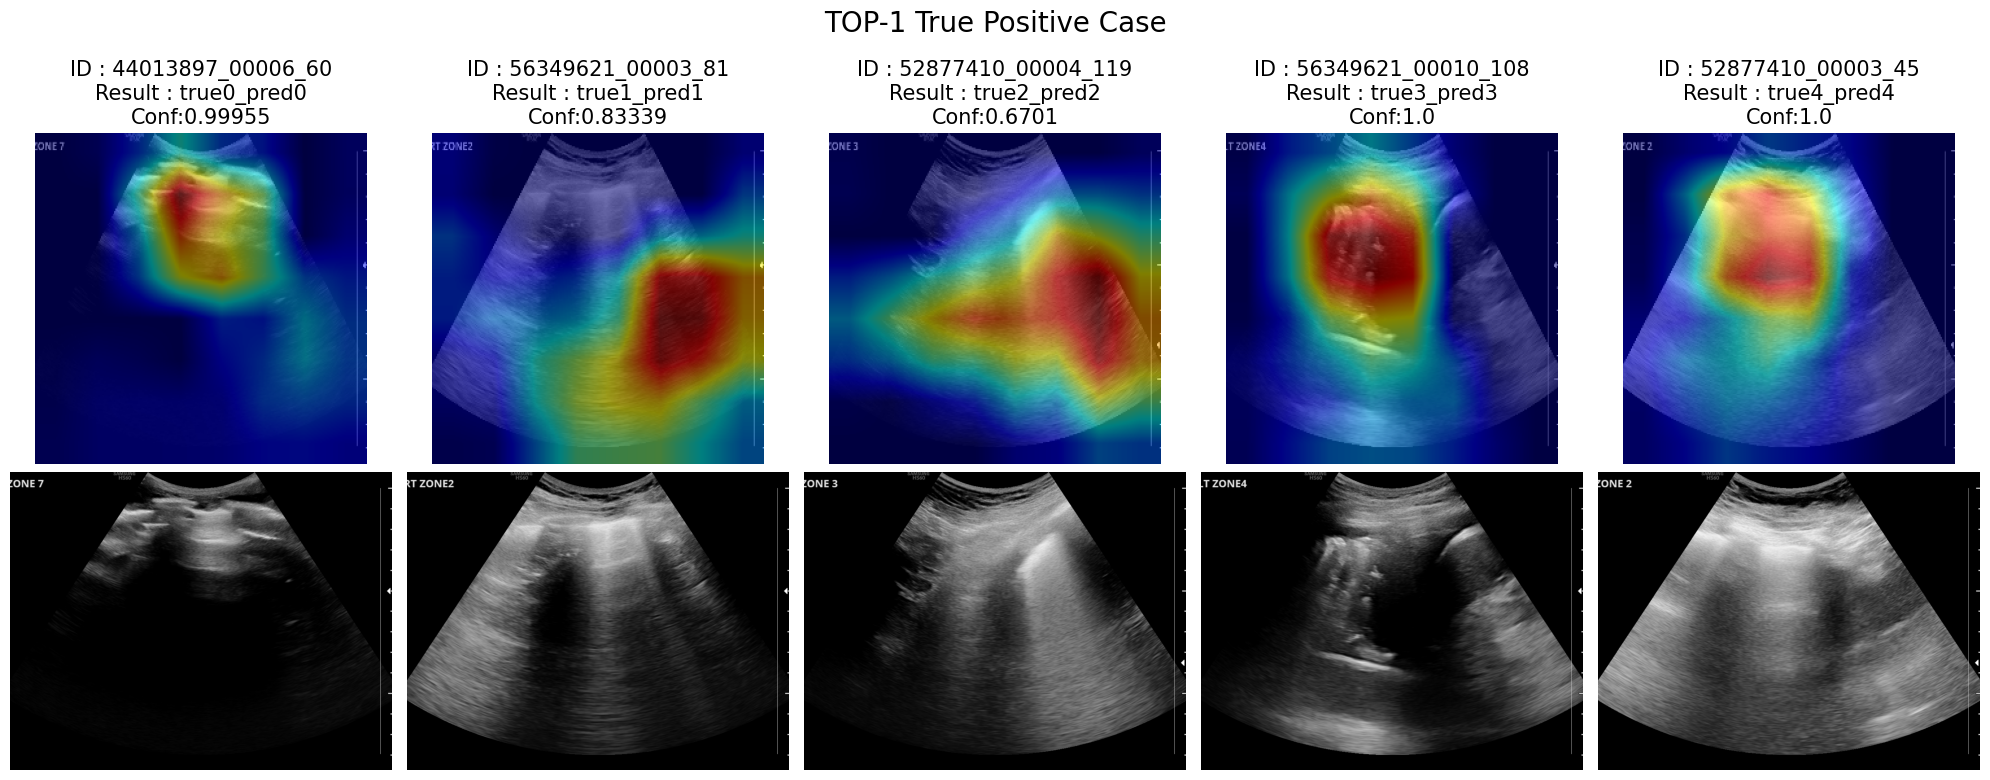

In [34]:
# Plot 설정 (2행 5열 구조로 설정)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 2행 5열 구조로 설정

original_img_paths = []

# 첫 번째 행에 Grad-CAM 이미지 plotting
for idx, (key, paths) in enumerate(top_images_per_class.items()):
    grad_cam_path = paths['TP'][0]  # Grad-CAM 이미지 경로
    
    match = re.search(r"true\d+_pred\d+", paths['TP'][0])
    result_str = match.group()
    
    base_filename = os.path.basename(paths['TP'][0])
    pred_prob = base_filename.split('_')[-1].split('.png')[0] # 확률 추출
    base_filename_without_extension = os.path.splitext(base_filename)[0] # "44013897_00006_60_true0_pred0_0.99955" 추출
    number_sequence = '_'.join(base_filename_without_extension.split('_')[:3]) # "44013897_00006_60" 추출
    
    org_img_path = f'/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/{number_sequence.split("_")[0]}/{number_sequence}.png'
    original_img_paths.append(org_img_path)
    
    base_filename.split('_')[-1].split('.png')[0]
    
    grad_cam_img = Image.open(grad_cam_path)  # 이미지 로딩
    axs[0, idx].imshow(grad_cam_img)  # 이미지 표시
    axs[0, idx].axis('off')  # 축 숨기기
    title = f"ID : {number_sequence}\nResult : {result_str}\nConf:{pred_prob}"
    axs[0, idx].set_title(title, fontsize=15)

# 두 번째 행에 원본 이미지 plotting
for idx, org_path in enumerate(original_img_paths):
    
    original_img = Image.open(org_path)
    axs[1, idx].imshow(original_img)  
    axs[1, idx].axis('off')  

plt.subplots_adjust(hspace=0.4)  # Adjust the space between rows
plt.suptitle('TOP-1 True Positive Case', fontsize=20, y=0.99)

plt.tight_layout()
plt.show()

### False Positive case
- 각 class에 대해서 probaility가 가장 높은 True Positive case 1개씩 추출

In [35]:
top_images_per_class

{0: {'TP': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_60_true0_pred0_0.99955.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_143_true0_pred0_0.90883.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_136_true0_pred0_0.99224.png'],
  'FP': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00007_118_true1_pred0_0.98497.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/52877410_00007_14_true4_pred0_1.0.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/41223316_00011_123_true4_pred0_0.99943.png'],
  'TN': ['/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00010_108_true3_pred3_1.0.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00008_142_true4_pred3_0.97084.png',
   '/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/52877410_00008_39_true1_

In [36]:
a = 0

for idx, (key, paths) in enumerate(top_images_per_class[a].items()):
    print(key)
    print(paths[0])
    print(len(top_images_per_class[a]))

TP
/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_60_true0_pred0_0.99955.png
4
FP
/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00007_118_true1_pred0_0.98497.png
4
TN
/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/56349621_00010_108_true3_pred3_1.0.png
4
FN
/home/workspace2/LUS/Results/Grad_CAM/densenet161_5class_fold4/44013897_00006_124_true0_pred3_0.98635.png
4


In [77]:
def plot_class_matrix_cases(class_dict, class_number, matrix_type):
    
    # Plot 설정 (2행 5열 구조로 설정)
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))  # 2행 5열 구조로 설정

    paths = class_dict[class_number][matrix_type] 
    
    original_img_paths = []
    for i in range(len(paths)):
        
        grad_cam_path = paths[i]

        match = re.search(r"true\d+_pred\d+", grad_cam_path)
        result_str = match.group()
        
        base_filename = os.path.basename(grad_cam_path)
        pred_prob = base_filename.split('_')[-1].split('.png')[0] # 확률 추출
        base_filename_without_extension = os.path.splitext(base_filename)[0] # "44013897_00006_60_true0_pred0_0.99955" 추출
        number_sequence = '_'.join(base_filename_without_extension.split('_')[:3]) # "44013897_00006_60" 추출
        
        org_img_path = f'/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/{number_sequence.split("_")[0]}/{number_sequence}.png'
        original_img_paths.append(org_img_path)
        
        base_filename.split('_')[-1].split('.png')[0]
        
        grad_cam_img = Image.open(grad_cam_path)  # 이미지 로딩
        axs[0, i].imshow(grad_cam_img)  # 이미지 표시
        axs[0, i].axis('off')  # 축 숨기기
        title = f"ID : {number_sequence}\nResult : {result_str}\nConf : {pred_prob}"
        axs[0, i].set_title(title, fontsize=15)
    
    # 두 번째 행에 원본 이미지 plotting
    for idx, org_path in enumerate(original_img_paths):
        
        original_img = Image.open(org_path)
        axs[1, idx].imshow(original_img)  
        axs[1, idx].axis('off')  

    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.7, top=0.3, wspace=0.1, hspace=0.1)  # Adjust the space between rows
    plt.suptitle(f'class_{class_number} TOP-5 {matrix_type} Cases', fontsize=20, y=0.97)

    plt.tight_layout()
    plt.show()

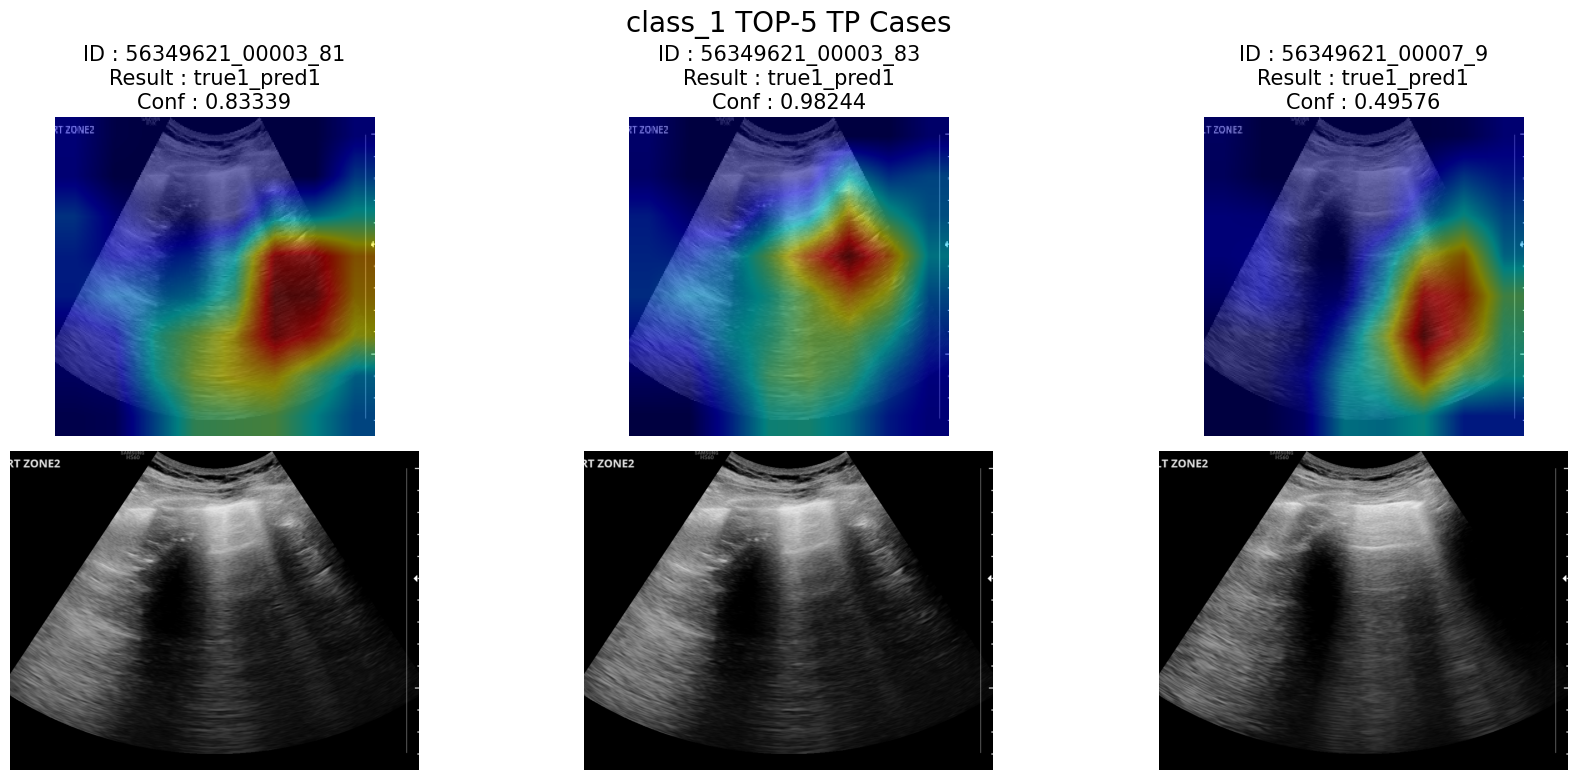

In [78]:
plot_class_matrix_cases(class_dict= top_images_per_class, class_number = 1, matrix_type='TP')

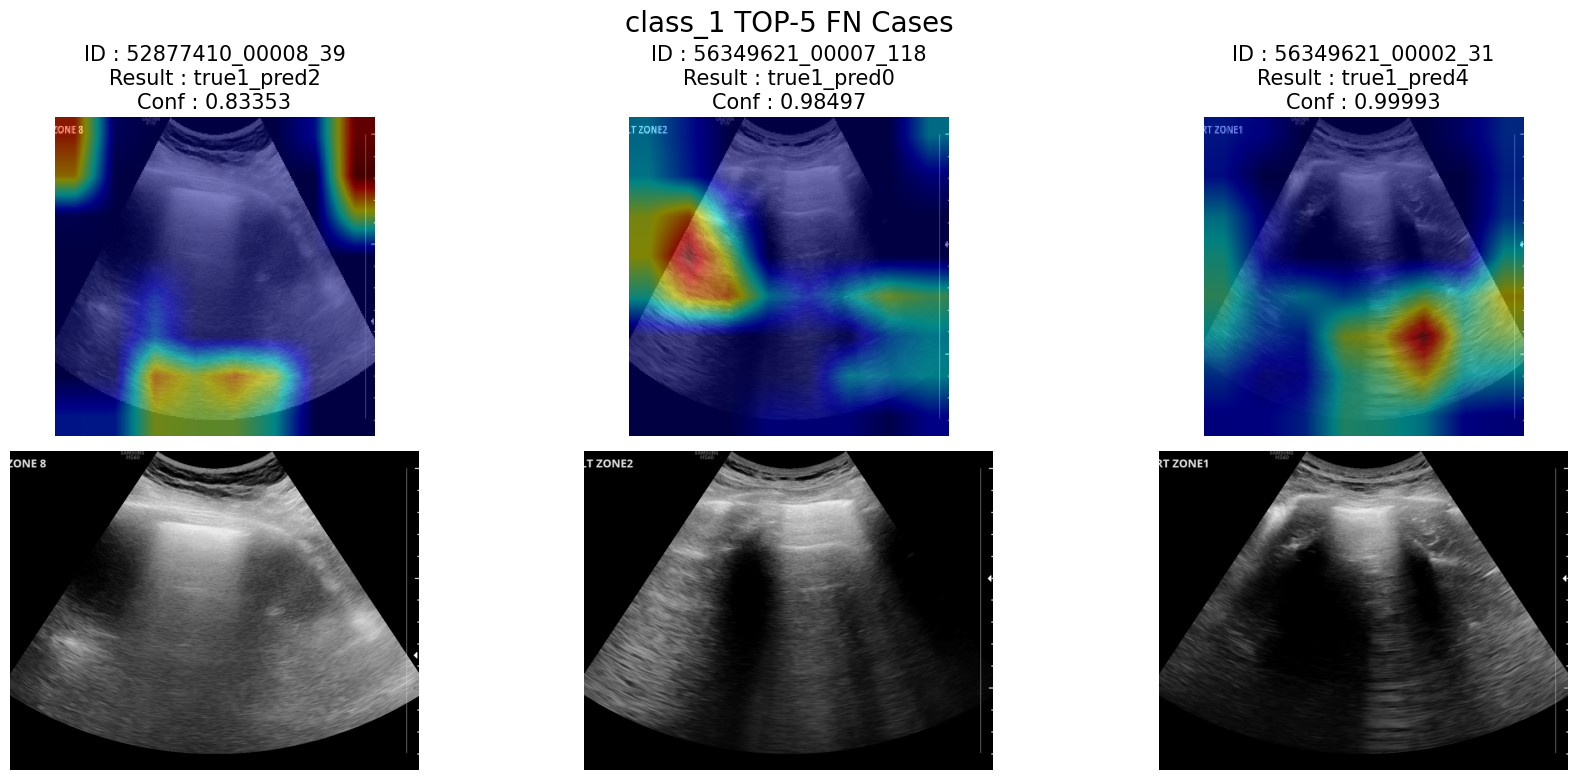

In [79]:
plot_class_matrix_cases(class_dict= top_images_per_class, class_number = 1, matrix_type='FN')

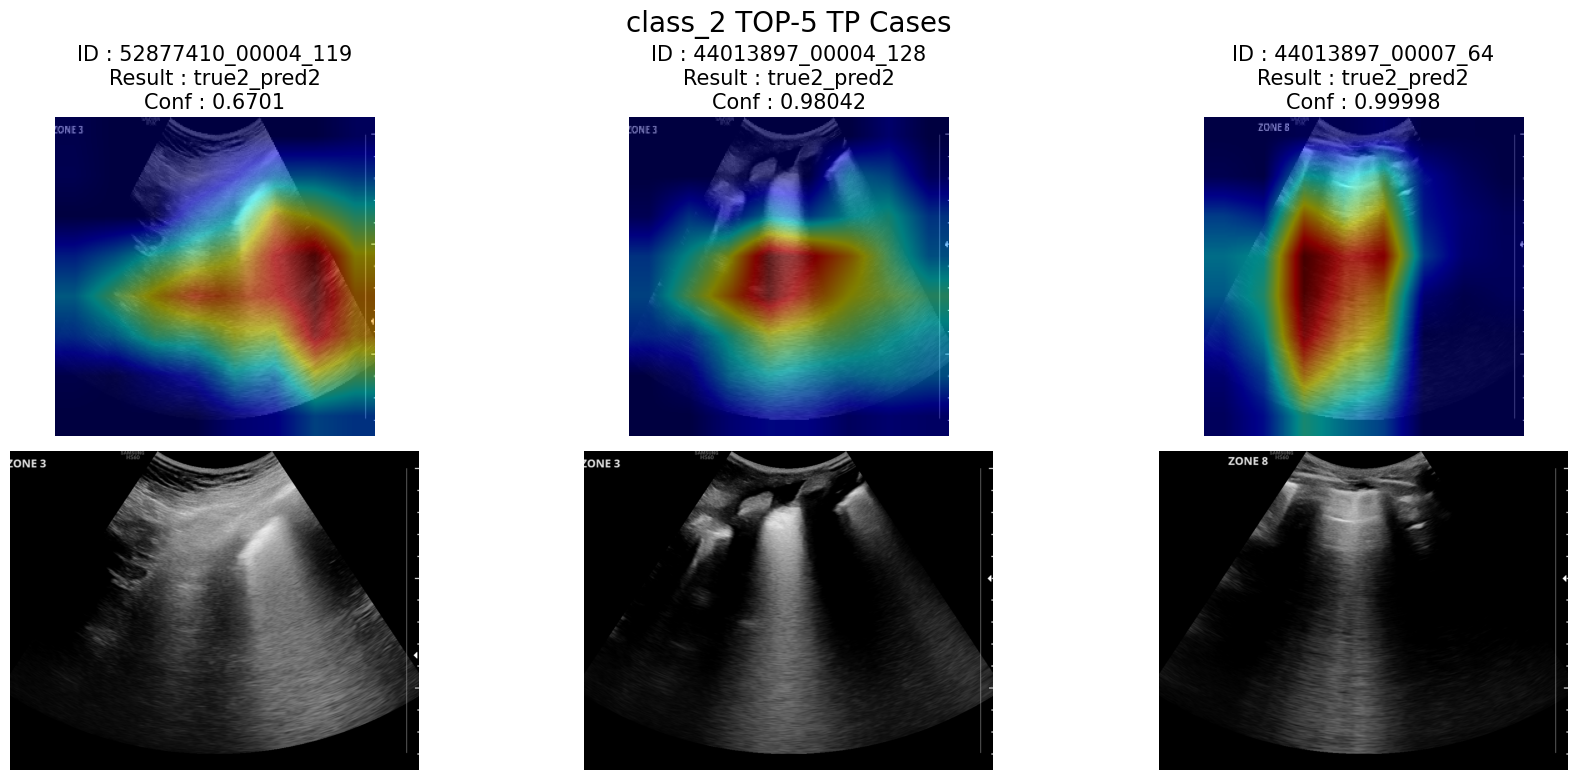

In [80]:
plot_class_matrix_cases(class_dict= top_images_per_class, class_number = 2, matrix_type='TP')

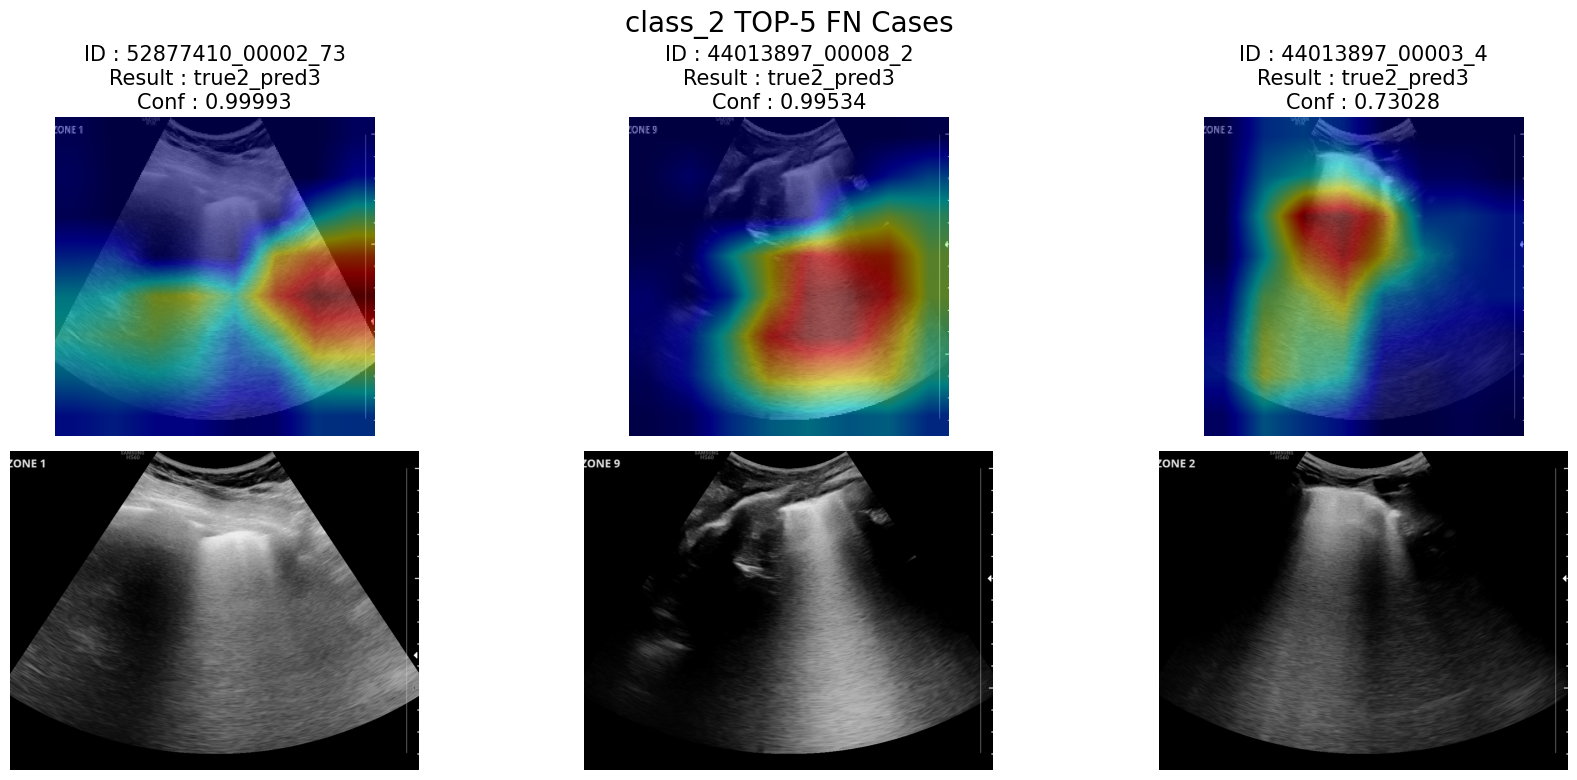

In [81]:
plot_class_matrix_cases(class_dict= top_images_per_class, class_number = 2, matrix_type='FN')

### LJH

In [324]:
true_0_pred_0_lst = []
true_1_pred_1_lst = []
true_2_pred_2_lst = []
true_3_pred_3_lst = []
true_4_pred_4_lst = []

for path in img_paths:
    
    true_label = path.split('/')[-1].split('_')[-2]
    pred_label = path.split('/')[-1].split('_')[-1].split('.')[0]
    
    if true_label == 'true0' and pred_label == 'pred0':
        true_0_pred_0_lst.append(path)
    elif true_label == 'true1' and pred_label == 'pred1':
        true_1_pred_1_lst.append(path)
    elif true_label == 'true2' and pred_label == 'pred2':
        true_2_pred_2_lst.append(path)
    elif true_label == 'true3' and pred_label == 'pred3':
        true_3_pred_3_lst.append(path)
    elif true_label == 'true4' and pred_label == 'pred4':
        true_4_pred_4_lst.append(path)

print(f'true_0_pred_0 수: {len(true_0_pred_0_lst)}')
print(f'true_1_pred_1 수: {len(true_1_pred_1_lst)}')
print(f'true_2_pred_2 수: {len(true_2_pred_2_lst)}')
print(f'true_3_pred_3 수: {len(true_3_pred_3_lst)}')
print(f'true_4_pred_4 수: {len(true_4_pred_4_lst)}')

true_0_pred_0 수: 207
true_1_pred_1 수: 4
true_2_pred_2 수: 430
true_3_pred_3 수: 985
true_4_pred_4 수: 893


In [341]:
selected_paths = []

for lst in [true_0_pred_0_lst, true_1_pred_1_lst, true_2_pred_2_lst, true_3_pred_3_lst, true_4_pred_4_lst]:
    chosen_path = random.choice(lst)
    selected_paths.append(chosen_path)
    print(chosen_path)

image_titles = ['True0_Pred0', 'True1_Pred1', 'True2_Pred2', 'True3_Pred3', 'True4_Pred4']

/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/56349621_00006_77_true0_pred0.png
/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/56349621_00007_9_true1_pred1.png
/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/44013897_00002_144_true2_pred2.png
/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/44013897_00009_6_true3_pred3.png
/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/52877410_00003_1_true4_pred4.png


In [342]:
import re

modified_paths = []
for path in selected_paths:
    # 폴더 이름(예: 41223316) 추출
    folder_name = path.split('/')[-1].split('_')[0]
    # _trueX_predX 부분 제거 및 경로 변경
    new_path = re.sub(r"_true\d+_pred\d+", "", path.replace('/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/', f'/LUS/Dataset/dcm_to_png/all_frame/version_1/{folder_name}/'))
    modified_paths.append(new_path)
    
all_image_paths = selected_paths + modified_paths
all_image_paths

['/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/56349621_00006_77_true0_pred0.png',
 '/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/56349621_00007_9_true1_pred1.png',
 '/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/44013897_00002_144_true2_pred2.png',
 '/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/44013897_00009_6_true3_pred3.png',
 '/home/workspace2/LUS/Results/Grad_CAM/densenet161_frame_base_fold4/52877410_00003_1_true4_pred4.png',
 '/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/56349621/56349621_00006_77.png',
 '/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/56349621/56349621_00007_9.png',
 '/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/44013897/44013897_00002_144.png',
 '/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/44013897/44013897_00009_6.png',
 '/home/workspace2/LUS/Dataset/dcm_to_png/all_frame/version_1/52877410/52877410_00003_1.png']

In [343]:
image_groups = {}
identifier_lst = []

# 이미지 경로를 그룹화
for path in selected_paths:
    # 파일명에서 전체 식별자 추출 (예: '56349621_00006_88')
    identifier = path.split('/')[-1].rsplit('.', 1)[0].rsplit('_', 2)[0]
    identifier_lst.append(identifier)
    
    if identifier not in image_groups:
        image_groups[identifier] = []

for id in identifier_lst:
    for i in all_image_paths:
        if id in i:
            image_groups[id].append(i)

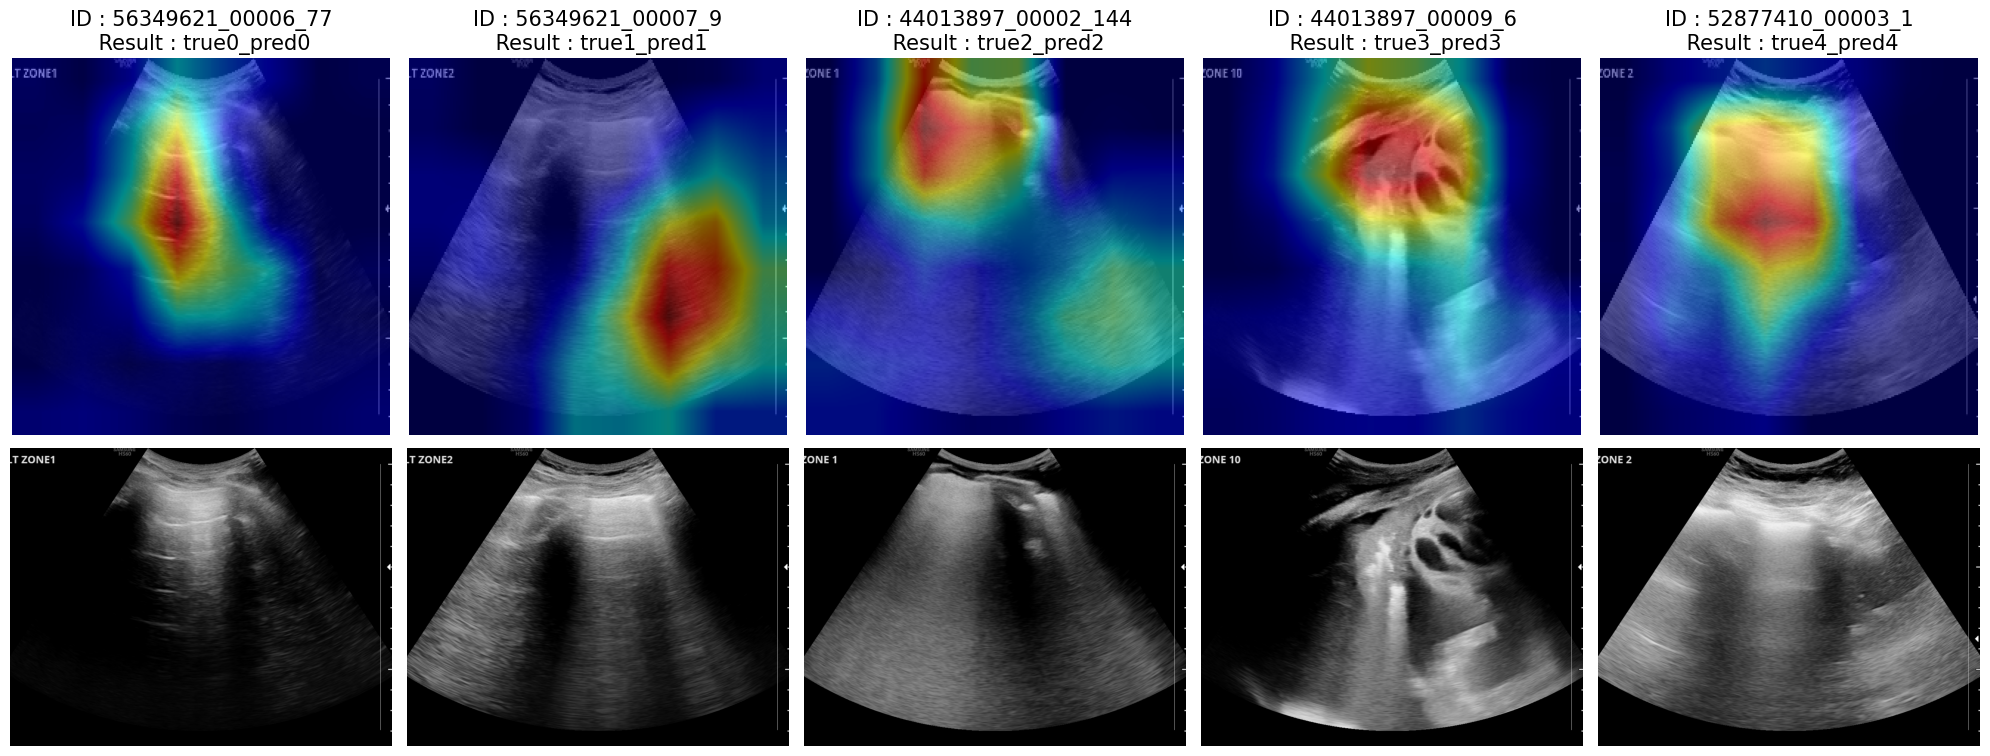

In [344]:
# Plot 설정 (2행 5열 구조로 설정)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 2행 5열 구조로 설정

# 첫 번째 행에 Grad-CAM 이미지 plotting
for idx, (key, paths) in enumerate(image_groups.items()):
    grad_cam_path = paths[0]  # Grad-CAM 이미지 경로
    
    match = re.search(r"true\d+_pred\d+", image_groups[key][0])
    result_str = match.group()
    
    grad_cam_img = Image.open(grad_cam_path)  # 이미지 로딩
    axs[0, idx].imshow(grad_cam_img)  # 이미지 표시
    axs[0, idx].axis('off')  # 축 숨기기
    title = f"ID : {key}\n Result : {result_str}"
    axs[0, idx].set_title(title, fontsize=15)
    # axs[0, idx].set_title(key)  # 파일명에서 고유 식별자 추출하여 제목으로 사용

# 두 번째 행에 원본 이미지 plotting
for idx, (key, paths) in enumerate(image_groups.items()):
    original_path = paths[1]  # 원본 이미지 경로
    original_img = Image.open(original_path)  # 이미지 로딩
    axs[1, idx].imshow(original_img)  # 이미지 표시
    axs[1, idx].axis('off')  # 축 숨기기
    # 여기서는 제목을 설정하지 않습니다. 필요하다면 추가할 수 있습니다.

plt.tight_layout()
plt.show()

In [339]:
test_df.head()

avi_id          study_id  PatientID  Data_idx  StudyDate Data_type  \
0  41223316_00002  41223316_00002_1   41223316         2   20230721     video   
1  41223316_00002  41223316_00002_2   41223316         2   20230721     video   
2  41223316_00002  41223316_00002_3   41223316         2   20230721     video   
3  41223316_00002  41223316_00002_4   41223316         2   20230721     video   
4  41223316_00002  41223316_00002_5   41223316         2   20230721     video   

   Label  Lung ultrasound score  frame_num  A-line  B-line  Confluent B-line  \
0      0                      0          1       1       0                 0   
1      0                      0          2       1       0                 0   
2      0                      0          3       1       0                 0   
3      0                      0          4       1       0                 0   
4      0                      0          5       1       0                 0   

   Consolidation  Pleural effusion  No finding  \
0              0                 0           0   
1              0                 0           0   
2              0                 0           0   
3              0                 0           0   
4              0                 0           0   

                                            img_path  
0  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...  
1  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...  
2  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...  
3  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...  
4  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...

In [340]:
test_df[test_df['study_id'] == '56349621_00010_82']

avi_id           study_id  PatientID  Data_idx  StudyDate  \
5249  56349621_00010  56349621_00010_82   56349621        10   20231025   

     Data_type  Label  Lung ultrasound score  frame_num  A-line  B-line  \
5249     video      3                      3         82       0       0   

      Confluent B-line  Consolidation  Pleural effusion  No finding  \
5249                 0              1                 1           0   

                                               img_path  
5249  /home/workspace2/LUS/Dataset/dcm_to_png/all_fr...